In [1]:
!pip install hyperopt
!pip install fasttext # necesario para importar los modulos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.1 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3163558 sha256=ff74669b1ccd46588a5e8d7df1023e41481790881070139ccbc1b5f100da91b5
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [2]:
# Clonamos el repo para usar el codigo de la lib
!git clone https://github.com/elsonidoq/ml-practico-2022.git 

Cloning into 'ml-practico-2022'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 193 (delta 102), reused 142 (delta 55), pack-reused 0
Receiving objects: 100% (193/193), 2.89 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [3]:
import sys
sys.path.append('ml-practico-2022/lib')

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
from taller_model_selection.evaluate import load_train_dev_test

(X_train, y_train), (X_dev, y_dev), test = load_train_dev_test('/content/gdrive/MyDrive/taller-model-selection-data')

{'pct(train)': 0.7837289649483001, 'pct(dev)': 0.11952685477518159, 'pct(test)': 0.09674418027651828}


In [6]:
from taller_model_selection.transformers import FeatureProjection
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

features_pipe = make_union(
    make_pipeline(
        FeatureProjection(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']),
        SimpleImputer()
    ),
    make_pipeline(
        FeatureProjection(['l3']), 
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse=False)
    ), 
    make_pipeline(
        FeatureProjection(['l4']), 
        SimpleImputer(strategy='constant'),
        OneHotEncoder(sparse=False)
    ), 
)

In [7]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

from taller_model_selection.evaluate import rmse

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    pipe = make_pipeline(
        features_pipe,
        lgb.LGBMRegressor(random_state=42, **params)
    )
    t0 = time()
    pipe.fit(X_train, y_train)
    train_time = time() - t0
    loss=rmse(y_dev, pipe.predict(X_dev))
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=rmse(y_train, pipe.predict(X_train)), 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

In [8]:
import numpy as np

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 300, 10),
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
    'objective': hp.choice('objective', ["regression", "regression_l1"]),
    'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
}

trials = Trials()

In [9]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

{'learning_rate': 0.01, 'n_estimators': 120, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}
loss 326678.52
{'learning_rate': 0.03, 'n_estimators': 210, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 338883.88
{'learning_rate': 0.28, 'n_estimators': 190, 'objective': 'regression_l1', 'reg_alpha': 0.03, 'subsample': 0.9}
loss 302535.26
{'learning_rate': 0.2, 'n_estimators': 250, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 298998.82
{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'regression_l1', 'reg_alpha': 0.02, 'subsample': 0.5}
loss 326321.34
{'learning_rate': 0.14, 'n_estimators': 230, 'objective': 'regression_l1', 'reg_alpha': 0.03, 'subsample': 0.8}
loss 305481.13
{'learning_rate': 0.05, 'n_estimators': 60, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 297630.20
{'learning_rate': 0.08, 'n_estimators': 280, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss

In [10]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res

In [11]:
import pandas as pd
df = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df.sort_values('loss').head()

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status
16,284310.917885,291552.414873,0.07,230,regression,0.00,0.5,3.811816,ok
8,284797.505669,289834.566501,0.08,230,regression,0.06,0.8,3.800815,ok
18,292932.677451,312131.428062,0.14,30,regression,0.00,0.8,2.547862,ok
6,297630.201665,319230.782055,0.05,60,regression,0.00,0.8,2.759688,ok
3,298998.822524,322398.190423,0.20,250,regression_l1,0.00,0.9,4.331656,ok


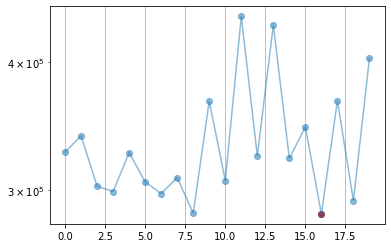

In [12]:
import matplotlib.pyplot as plt

df.loss.plot(style='-o', alpha=0.5)
plt.scatter([df.loss.argmin()], [df.loss.min()], c='r')
# df.tr_loss.plot()
plt.yscale('log')
plt.grid()

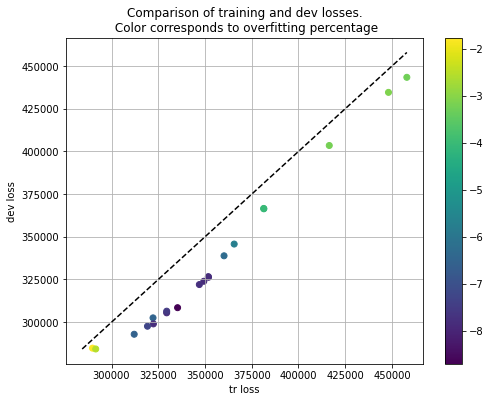

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(df.tr_loss, df.loss, c=(df.loss-df.tr_loss)/df.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df.tr_loss.min(), df.loss.min())
M = max(df.tr_loss.max(), df.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

In [14]:
cut_point = df.loss.median()
best_models_df = df[df.loss <= cut_point]
worst_models_df = df[df.loss > cut_point]


def visualize_param(param_name):
  s = df[f'params.{param_name}']
  if s.dtype.name == 'object':
    visualize_categorical_param(param_name)
  else: # assume numerical
    visualize_numerical_param(param_name)

def visualize_categorical_param(param_name):
    pd.concat([
      best_models_df[f'params.{param_name}'].value_counts().rename('best'),
      worst_models_df[f'params.{param_name}'].value_counts().rename('worst')
  ], axis=1).plot.bar()

def visualize_numerical_param(param_name):
  plt.violinplot([
      best_models_df[f'params.{param_name}'],
      worst_models_df[f'params.{param_name}']
  ])
  plt.xticks([1, 2], ['best', 'worst'])

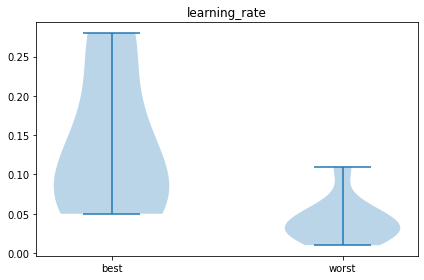

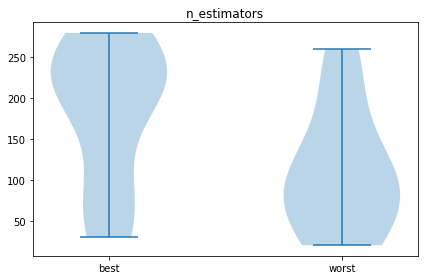

<Figure size 432x288 with 0 Axes>

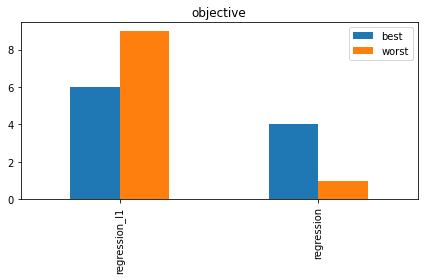

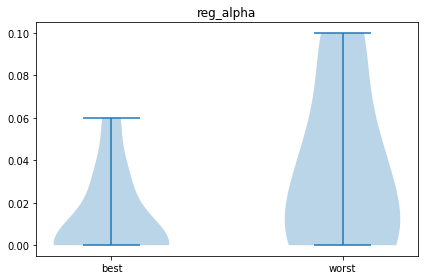

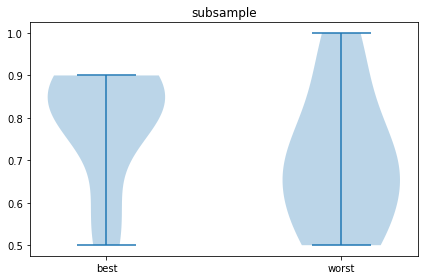

In [15]:
param_names = list(trials.trials[0]['result']['params'].keys())
for param_name in param_names:
  plt.figure()
  visualize_param(param_name)
  plt.title(param_name)
  plt.tight_layout()

# Elegimos el champion y hacemos error analysis

In [16]:
# El que menos overfittea de los mejors
best = df[df.loss < df.loss.min() * 1.001].sort_values('tr_loss', ascending=False).head(30)
best

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status
16,284310.917885,291552.414873,0.07,230,regression,0.0,0.5,3.811816,ok


In [17]:
params = {k.replace('params.', ''):v for k, v in best.iloc[0].to_dict().items() if 'params.' in k}
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMRegressor(random_state=42, **params)
)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojection',
                                                                  FeatureProjection(fields=['rooms',
                                                                                            'bedrooms',
                                                                                            'bathrooms',
                                                                                            'surface_total',
                                                                                            'surface_covered'])),
                                                                 ('simpleimputer',
                                                                  SimpleImputer())])),
                                                ('pipeline-2',
                                                 Pi

In [18]:
# Con el modelo entrenado, generamos predicciones 
# y calculamos el error por cada ejemplo

y_hat_dev = rf_pipe.predict(X_dev)
y_dev = np.asarray(y_dev)
err_dev = y_dev - y_hat_dev
rmse(y_dev, y_hat_dev)

284310.91788532597

In [19]:
best.loss.iloc[0] # validamos que da el mismo error que lo que tuvimos en el model selection

284310.91788532597

In [20]:
# Ahora vamos a elegir los ejemplos donde mas le pifiamos por arriba
# O sea, donde el error (true - predicted) es negativo y muy bajo

worst_over_price = np.percentile(err_dev, 5)
over_price_examples = [dict(x=e, y=y_dev[i], y_hat=y_hat_dev[i]) for i, e in enumerate(X_dev) if err_dev[i] < worst_over_price]
worst_over_price, len(over_price_examples)

# Ahora vamos a elegir los ejemplos donde mas le pifiamos por abajo
# O sea, donde el error (true - predicted) es positivo y muy alto
worst_under_price = np.percentile(err_dev, 95)
under_price_examples = [dict(x=e, y=y_dev[i], y_hat=y_hat_dev[i]) for i, e in enumerate(X_dev) if err_dev[i] > worst_under_price]
worst_under_price, len(under_price_examples)

(177280.67680540305, 964)

# Visualizamos los ejemplos con mas error en cada punta

In [21]:
from random import sample
from IPython.display import display_markdown, display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def display_examples(examples, n=3):
  for ex in sample(examples, n):
    display_markdown(f'###{ex["x"]["title"]}', raw=True)
    display(pd.Series(dict(
        true_price=ex['y'], predicted_price=ex['y_hat'],
        absolute_error=abs(ex['y'] - ex['y_hat']), relative_error=abs(ex['y'] - ex['y_hat'])/ex['y'], 
    )))
    display_markdown('###Description', raw=True)
    display_markdown(ex['x']['description'][:300] + ' ...', raw=True)
    display(pd.Series(ex['x']).drop(index=['description', 'title']))


display_markdown("#Under price examples", raw=True)
display_examples(under_price_examples)

display_markdown("#Over price examples", raw=True)
display_examples(over_price_examples)

#Under price examples

###Terreno - Villa del Parque

true_price        650000.000
predicted_price   394689.403
absolute_error    255310.597
relative_error         0.393
dtype: float64

###Description

LOTE PARA CONSTRUIR  en Excelente Ubicacion- Villa del Parque<br><br>Unidad de sustentabilidad: ALTURA ALTA<br><br>SUPERFICIE VENDIBLE 1561 M² y  9  COCHERAS en PB. Prefactibilidad a Disposicion.<br><br>EXCELENTE LOTE   9.63 x 41.21  <br><br> EN INMEJORABLE UBICACION - ALTURA MAXIMA 22.80 -Cantidad  ...

id                 BzFcfGJCPGDFeE0PQ8fayA==
ad_type                           Propiedad
start_date                       2021-03-04
end_date                         2021-05-18
created_on                       2021-03-04
lat                                 -34.607
lon                                 -58.498
l1                                Argentina
l2                          Capital Federal
l3                         Villa del Parque
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                   NaN
bedrooms                                NaN
bathrooms                               NaN
surface_total                           NaN
surface_covered                         NaN
currency                                USD
price_period                        Mensual
property_type                          Lote
operation_type                        Venta
dtype: object

###RETASADO CHATEAU LIBERTADOR Único depto ALTO con gran  terraza propia USD 2.100.000  Excelente!

true_price        2100000.000
predicted_price   1723798.257
absolute_error     376201.743
relative_error          0.179
dtype: float64

###Description

LIVING / COMEDOR, TOILETTE, BALCóN ATERRAZADO, 3 SUITES, 2 FAMILY ROOMS, COMEDOR DIARIO, 1 DEPENDENCIA, 2 COCHERAS FIJAS, BAULERA, IMPORTANTES AMENITIES, MáXIMA SEGURIDAD, LAUNDRY
<br>
<br>Increible vista al río y ciudad - 
<br>Antiguedad: 8 años - 
<br>Orientación: sureste - 
<br>Superficie cubiert ...

id                 UkA6YnAqZVBl6Iz00Z+2LQ==
ad_type                           Propiedad
start_date                       2021-03-17
end_date                         2021-04-14
created_on                       2021-03-17
lat                                 -34.548
lon                                 -58.456
l1                                Argentina
l2                          Capital Federal
l3                                    Nuñez
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 5.000
bedrooms                              3.000
bathrooms                             3.000
surface_total                       431.000
surface_covered                     291.000
currency                                USD
price_period                        Mensual
property_type                  Departamento
operation_type                        Venta
dtype: object

###Galpón - Floresta Norte

true_price        2100000.000
predicted_price    855767.204
absolute_error    1244232.796
relative_error          0.592
dtype: float64

###Description

Magnifico y único galpón sobre av Gaona con salida a Sanabria<br>17,32 mts sobre la avenida con entrada de camiones, galpón con techo de losa a 4 mts de altura y sobre la calle Sanabria entrada de camión con techo de chapa a 5 mts de altura. Posee baños y vestuarios para ambos sexos. Sector de ofici ...

id                 e8HsGSJamzijbmR+Rm0afg==
ad_type                           Propiedad
start_date                       2021-03-15
end_date                         2021-06-05
created_on                       2021-03-15
lat                                 -34.627
lon                                 -58.489
l1                                Argentina
l2                          Capital Federal
l3                                 Floresta
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                   NaN
bedrooms                                NaN
bathrooms                             5.000
surface_total                       800.000
surface_covered                     800.000
currency                                USD
price_period                        Mensual
property_type                          Otro
operation_type                        Venta
dtype: object

#Over price examples

###Cochera en Venta en Belgrano, Capital federal U$S 19000

true_price         19000.000
predicted_price   296990.534
absolute_error    277990.534
relative_error        14.631
dtype: float64

###Description

Tiene ascensor y Vigilancia las 24hs Las medidas, superficies y montos de expensas consignadas en la presente descripción son aproximadas, a solo título orientativo y no son vinculantes. Las medidas y superficies reales surgen del Título respectivo, y el monto de expensas real, del recibo emitido po ...

id                 yf93q0sTA23ROiQLQ6ZnNw==
ad_type                           Propiedad
start_date                       2021-04-15
end_date                         2021-04-15
created_on                       2021-04-15
lat                                 -34.571
lon                                 -58.448
l1                                Argentina
l2                          Capital Federal
l3                                 Belgrano
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 1.000
bedrooms                                NaN
bathrooms                               NaN
surface_total                           NaN
surface_covered                         NaN
currency                                USD
price_period                        Mensual
property_type                       Cochera
operation_type                        Venta
dtype: object

###Cochera - Villa Urquiza

true_price         25000.000
predicted_price   420783.716
absolute_error    395783.716
relative_error        15.831
dtype: float64

###Description

Cochera en venta<br>a 1 cuadra y 1/2 de Av. los Incas y a dos cuadras de subte línea B de Av de los Incas<br><br><br>Listo para tomar posesión<br><br> ...

id                 UeN1RDY6HCinH5wVOnUNTg==
ad_type                           Propiedad
start_date                       2021-03-17
end_date                         2021-06-05
created_on                       2021-03-17
lat                                 -34.584
lon                                 -58.476
l1                                Argentina
l2                          Capital Federal
l3                            Villa Urquiza
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                   NaN
bedrooms                                NaN
bathrooms                               NaN
surface_total                           NaN
surface_covered                         NaN
currency                                USD
price_period                        Mensual
property_type                       Cochera
operation_type                        Venta
dtype: object

###Cochera en Venta en Belgrano, Capital federal U$S 26000

true_price         26000.000
predicted_price   296990.534
absolute_error    270990.534
relative_error        10.423
dtype: float64

###Description

EXCELENTE UBICACION A 1/2 CUADRA DE AV. CABILDO. Las medidas, superficies y montos de expensas consignadas en la presente descripción son aproximadas, a solo título orientativo y no son vinculantes. Las medidas y superficies reales surgen del Título respectivo, y el monto de expensas real, del recib ...

id                 jjk0ObieX9E5A+x7hkOU9g==
ad_type                           Propiedad
start_date                       2021-04-14
end_date                         2021-04-14
created_on                       2021-04-14
lat                                 -34.566
lon                                 -58.451
l1                                Argentina
l2                          Capital Federal
l3                                 Belgrano
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 1.000
bedrooms                                NaN
bathrooms                               NaN
surface_total                           NaN
surface_covered                         NaN
currency                                USD
price_period                        Mensual
property_type                       Cochera
operation_type                        Venta
dtype: object

Pareciera haber algo con el property type.
Veamos la distribucion

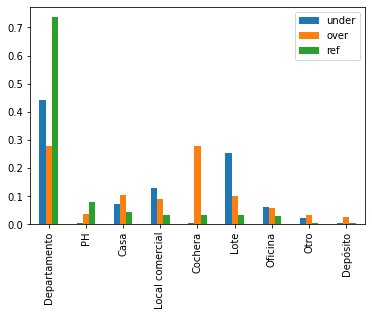

In [22]:
under_distr = (
    pd.DataFrame([e['x'] for e in under_price_examples])
    .property_type.value_counts(normalize=True).rename('under')
)
over_distr = (
    pd.DataFrame([e['x'] for e in over_price_examples])
    .property_type.value_counts(normalize=True).rename('over')
)
ref_distr = (
    pd.DataFrame([e for e in X_dev])
    .property_type.value_counts(normalize=True).rename('ref')
)

(
  pd.concat([under_distr, over_distr, ref_distr], axis=1)
  .sort_values('ref', ascending=False).dropna().plot.bar()
)

# Evaluamos el modelo en el test set

In [23]:
X_test, y_test = test

In [24]:
best_model_performance = dict(
    tr_loss=rmse(y_train, rf_pipe.predict(X_train)), 
    dev_loss=rmse(y_dev, rf_pipe.predict(X_dev)),
    test_loss=rmse(y_test, rf_pipe.predict(X_test)), 
)
best_model_performance

{'tr_loss': 291552.41487266193,
 'dev_loss': 284310.91788532597,
 'test_loss': 235704.0023660517}